# Example 1

### Proposed task
**Dataset**: We have a set of images, with file names in the following format: month_x_band_y.tif, where x is the month and y is the band name (Example: month_1_band_B02.tif).

The code must be able to:
- Create, for each band, a stack of monthly images.
- Create vegetation indices for each image.
- Create time composites for each band (e.g. median, mean, maximum, minimum).
- Plot the vegetation indices (single-band plot) and RGB composites (three-band plot) for the time composites.
- Export the time composites as GeoTIFF files.

### Current implementation
This notebook provides a simple code to implement the proposed task. However, it does not have a structured code and does not allow us to to change configurations easily. For example, if we add a new vegetation index, we need to make several changes in the code to create a time composite of this new index, plot it and export it.

### Refactored implementation
A refactored code is implemented in the notebook `example_refactored.ipynb`. More details about the refactored code can be found in the mentioned notebook.

In [1]:
from pathlib import Path
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [20]:
DATA_FOLDER = '../data/example_images/'
EXPORT_FOLDER = './processed_data/'

In [3]:
data_folder = Path(DATA_FOLDER)
file_paths = list(data_folder.glob('**/*.tif'))

In [4]:
sample_path = file_paths[0]
sample_path

WindowsPath('../data/example_images/1/month_1_band_B02.tif')

In [5]:
print(sample_path.stem.split('_'))
month = sample_path.stem.split('_')[1]
month = int(month)
band = sample_path.stem.split('_')[3]
print(month, band)

['month', '1', 'band', 'B02']
1 B02


In [6]:
months = [int(p.stem.split('_')[1]) for p in file_paths]
bands = [p.stem.split('_')[3] for p in file_paths]

In [10]:
# For each band, stack months 7 to 10 in a list
target_months = [7,8,9,10]
band_stack = {}
for i in range(len(file_paths)):
    file_path = file_paths[i]
    month = months[i]
    band = bands[i]
    
    if month not in target_months:
        continue
    
    # Read raster
    with rasterio.open(file_path) as src:
        raster = src.read()
    
    if band not in band_stack.keys():
        band_stack[band] = []
    band_stack[band].append(raster)

In [11]:
# Compute NDVI and EVI
red_band_stack = band_stack['B04']
nir_band_stack = band_stack['B08']
blue_band_stack = band_stack['B02']

ndvi = []
for red, nir in zip(red_band_stack, nir_band_stack):
    ndvi_result = (nir - red) / (nir + red)
    ndvi.append(ndvi_result)
    
evi = []
for red, nir, blue in zip(red_band_stack, nir_band_stack, blue_band_stack):
    evi_result = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
    evi.append(evi_result)

In [12]:
# Concat stack as a 3D array
ndvi = np.concatenate(ndvi, axis=0)
evi = np.concatenate(evi, axis=0)

In [13]:
# Get mean and max of NDVI and EVI over time
ndvi_mean = np.nanmean(ndvi, axis=0)
ndvi_max = np.nanmax(ndvi, axis=0)
evi_mean = np.nanmean(evi, axis=0)
evi_max = np.nanmax(evi, axis=0)

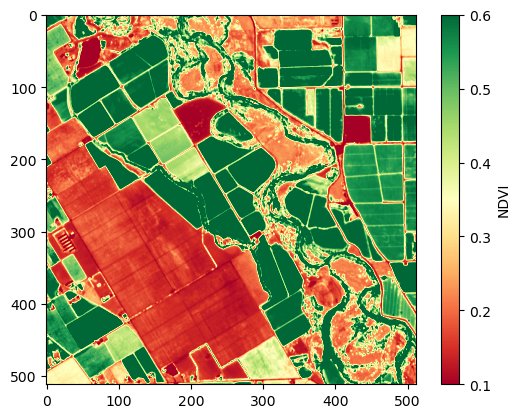

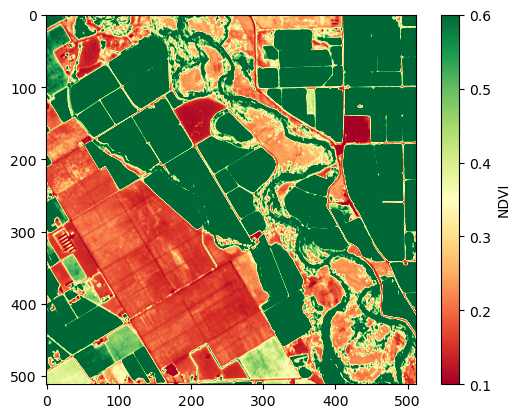

In [14]:
plt.imshow(ndvi_mean, cmap='RdYlGn', vmin=0.1, vmax=0.6)
plt.colorbar(label='NDVI')
plt.show()
plt.imshow(ndvi_max, cmap='RdYlGn', vmin=0.1, vmax=0.6)
plt.colorbar(label='NDVI')
plt.show()

In [23]:
# Export tif files
# Create folder for each vegetation index
export_folder = Path(EXPORT_FOLDER)
export_folder.mkdir(parents=True, exist_ok=True)


sample_file = file_paths[0]
with rasterio.open(sample_file) as src:
    profile = src.profile

# Export NDVI
file_path_export = export_folder / "ndvi_mean.tif"
with rasterio.open(file_path_export, "w", **profile) as dst:
    dst.write(np.expand_dims(ndvi_mean, axis=0))
file_path_export = export_folder / "ndvi_std.tif"
with rasterio.open(file_path_export, "w", **profile) as dst:
    dst.write(np.expand_dims(ndvi_max, axis=0))
    
# Export EVI
file_path_export = export_folder / "evi_mean.tif"
with rasterio.open(file_path_export, "w", **profile) as dst:
    dst.write(np.expand_dims(evi_mean, axis=0))
file_path_export = export_folder / "evi_std.tif"
with rasterio.open(file_path_export, "w", **profile) as dst:
    dst.write(np.expand_dims(evi_max, axis=0))